# **Gestión de Datos**

## Práctica 2: Análisis de Datos de Películas

*Autores: Pablo López Perez y Daniel Beteta Francisco*

# **Objetivos:**

1. Para cada año de los que haya información, lista de géneros con la media de
puntuación para cada uno, ordenados de mayor a menos según esta media.

2. Para cada uno de los géneros encontrados, evolución de las puntuaciones
medias anuales a lo largo de los años.

# **0. Librerías utilizadas**

In [ ]:
import re
import math
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tabulate import tabulate
from google.colab import drive

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# **1. Carga de los datos y descripción de las transformaciones a realizar**

In [ ]:
df_movies = pd.read_csv("/content/drive/My Drive/GD/movies.csv")

df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_ratings = pd.read_csv("/content/drive/My Drive/GD/ratings.csv")

df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Las operaciones que se van a llevar a cabo a la vista de los datos son las siguientes:

1. Eliminar filas repetidas en ambos datasets. Notar que para el dataframe de ratings se considera repetido si un usuario da la misma reseña a una misma película en dos momentos diferentes de tiempo.

2. Elimar la columna "userId" ya que no es relevante para el análisis. 

3. Juntar ambos DataFrames en uno solo mediante la columna "movieId" comprobando que dicho valor sea en todo caso numérico. 

4. Generar una nueva columna con el año de lanzamiento de la película, esta columna nos servirá posteriormente para comprobar que las críticas a la película se produzcan de ese mismo año en adelante. Notar que si no se encuentra el año de lanzamiento, este será "0".

5. Obtener los diferentes géneros del total de películas y guardarlos en un pickle file.

6. Convertir la columna de "timestamp" de segundos desde el 1 de Enero de 1970 al año en el que se realizó la crítica.

7. Comprobar que los ratings están entre 0.5 y 5.

8. Guardar el DataFrame obtenido en un pickle file para evitar repetir las anteriores transformaciones cada que se entre al notebook.

# **2. Preparación de los datos**

*Eliminar filas repetidas*

In [ ]:
print(df_movies.shape)
df_movies.drop_duplicates()
print(df_movies.shape)

(62423, 3)
(62423, 3)


In [ ]:
print(df_ratings.shape)
df_ratings.drop_duplicates(subset=["userId", "movieId", "rating"])
print(df_ratings.shape)

(25000095, 4)
(25000095, 4)


*Eliminar columna "userId"*

In [ ]:
df_ratings.drop("userId", axis=1, inplace=True)

df_ratings.head()

,movieId,rating,timestamp
0,296,5.0,1147880044
1,306,3.5,1147868817
2,307,5.0,1147868828
3,665,5.0,1147878820
4,899,3.5,1147868510


*Juntar ambos DataFrames*

In [ ]:
pd.to_numeric(df_movies['movieId'], errors='coerce').notnull().all()

True

In [ ]:
pd.to_numeric(df_ratings['movieId'], errors='coerce').notnull().all()

True

In [ ]:
df = pd.merge(df_movies, df_ratings, on='movieId')

df

,movieId,title,genres,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,890492517
...,...,...,...,...,...
24751325,209157,We (2018),Drama,1.5,1574280748
24751326,209159,Window of the Soul (2001),Documentary,3.0,1574280985
24751327,209163,Bad Poems (2018),Comedy|Drama,4.5,1574284913
24751328,209169,A Girl Thing (2001),(no genres listed),3.0,1574291826


*Generar nueva columna de año de lanzamiento*

In [ ]:
new_titles_list, release_year_list, not_found_release_year = list(), list(), list()

for title in df["title"]:
  matches_found = re.findall(r"\(\d{4}\)", title)
  if len(matches_found) >= 1:
    release_year = re.sub(r"[\(\)]", "", matches_found[-1])
    release_year_list.append(int(release_year))
  else:
    release_year_list.append(0)
    not_found_release_year.append(title)

  new_title = title
  for match_found in matches_found:
    new_title = new_title.replace(match_found, "") 
  new_titles_list.append(new_title)

df_not_found_release_year = pd.DataFrame({"Not found release year": list(set(not_found_release_year))})

df_not_found_release_year

,Not found release year
0,Hitler's Olympics
1,Seat 25
2,A Dark Place Inside
3,Dhund: The Fog
4,In Search of Fellini
...,...
362,Fakta Ladh Mhana
363,The Serious Game
364,BlueGreen
365,A Miracle on Christmas Lake


In [ ]:
df["title"] = new_titles_list
df["release_year"] = release_year_list

df.head()

,movieId,title,genres,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.5,1141415820,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1439472215,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.0,1573944252,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,858625949,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,890492517,1995


*Obtener los diferentes géneros y guardarlos en un pickle file*

In [ ]:
set_of_genres = set()

for row_genres in set(df["genres"]):
  for genre in row_genres.split("|"):
    if genre not in set_of_genres:
      set_of_genres.add(genre)

set_of_genres.remove("(no genres listed)")

df_genres = pd.DataFrame({"Genres": list(set_of_genres)})

df_genres

,Genres
0,Thriller
1,IMAX
2,Crime
3,Musical
4,Science fiction
5,Children
6,Film-Noir
7,Sci-Fi
8,Documentary
9,Comedy


In [ ]:
with open('set_of_genres.pickle', 'wb') as handle:
    pickle.dump(set_of_genres, handle, protocol=pickle.HIGHEST_PROTOCOL)

*Transformación de la columna "timestamp"*

In [ ]:
list_years = list()
initial_year = 1970
second_in_a_year = 365 * 24 * 60 * 60

for time in df["timestamp"]:
  year = initial_year + math.floor(time / second_in_a_year)
  list_years.append(year)

df["timestamp"] = list_years

df.head()

,movieId,title,genres,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.5,2006,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,2015,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.0,2019,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1997,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1998,1995


In [ ]:
print(df.shape)
df = df[df["timestamp"] >= df["release_year"]]
print(df.shape)

(24751330, 6)
(24750498, 6)


Aquí se ve una clara limitación a este filtro de coherencia, y es que si se hubiera podido obtener el año de lanzamiento de todas las películas, probablemente, también se hubiera podido descartar reseñas incompatibles temporalmente.

*Filtrado ratings*

In [ ]:
df["rating"] = pd.to_numeric(df["rating"])

print(df.shape)
df = df[(df["rating"] >= 0.5) & (df["rating"] <= 5)] 
print(df.shape)

(24750498, 6)


<ipython-input-16-c74cddc84fab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"] = pd.to_numeric(df["rating"])


(23660033, 6)


*Guardar el DataFrame obtenido en un pickle file*

In [ ]:
df

,movieId,title,genres,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.5,2006,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,2015,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.0,2019,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1997,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1998,1995
...,...,...,...,...,...,...
24751325,209157,We,Drama,1.5,2019,2018
24751326,209159,Window of the Soul,Documentary,3.0,2019,2001
24751327,209163,Bad Poems,Comedy|Drama,4.5,2019,2018
24751328,209169,A Girl Thing,(no genres listed),3.0,2019,2001


In [ ]:
with open('DataFrame_transformed.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **3. Computación de los objetivos**

In [ ]:
with open('/content/drive/My Drive/GD/set_of_genres.pickle', 'rb') as handle:
    set_of_genres = pickle.load(handle)

In [ ]:
with open('/content/drive/My Drive/GD/DataFrame_transformed.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [ ]:
df

,movieId,title,genres,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.5,2006,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,2015,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3.0,2019,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1997,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4.0,1998,1995
...,...,...,...,...,...,...
24751325,209157,We,Drama,1.5,2019,2018
24751326,209159,Window of the Soul,Documentary,3.0,2019,2001
24751327,209163,Bad Poems,Comedy|Drama,4.5,2019,2018
24751328,209169,A Girl Thing,(no genres listed),3.0,2019,2001


Estructura seguida:

{
  "Año1":
    {
      "Género1": "Puntuación",
      "Género2": "Puntuación"
    },
  "Año2":
    {
      "Género1": "Puntuación",
      "Género2": "Puntuación"
    },
}

In [ ]:
dict_first_goal = dict()
all_years = range(min(list(df["timestamp"])), max(list(df["timestamp"]))+1)

for year in all_years:
  dict_first_goal[year] = dict()
  year_df = df[df["timestamp"]==year]
  for genre in set_of_genres:
    genre_df = year_df[year_df["genres"].str.contains(genre)]
    dict_first_goal[year][genre] = genre_df["rating"].mean()

Estructura seguida:

{
  "Género1":
    {
      "Año1": "Puntuación",
      "Año2": "Puntuación"
    },
  "Género2":
    {
      "Año1": "Puntuación",
      "Año2": "Puntuación"
    },
}

In [ ]:
dict_second_goal = dict()

for genre in set_of_genres:
  dict_second_goal[genre] = dict()
  genre_df = df[df["genres"].str.contains(genre)]
  for year in all_years:
    year_df = genre_df[genre_df["timestamp"]==year]
    dict_second_goal[genre][year] = year_df["rating"].mean()

# **4. Representación gráfica de los resultados**

In [ ]:
dict_first_plot = {genre: [list(all_years)] for genre in set_of_genres}

for genre in set_of_genres:
  punctuations_of_given_genre = list()
  for year in all_years:
    punctuation = dict_first_goal[year][genre]
    if math.isnan(punctuation):
      # To improve the visualization readability
      punctuations_of_given_genre.append(3)
    else:
      punctuations_of_given_genre.append(punctuation)
  dict_first_plot[genre].append(punctuations_of_given_genre)

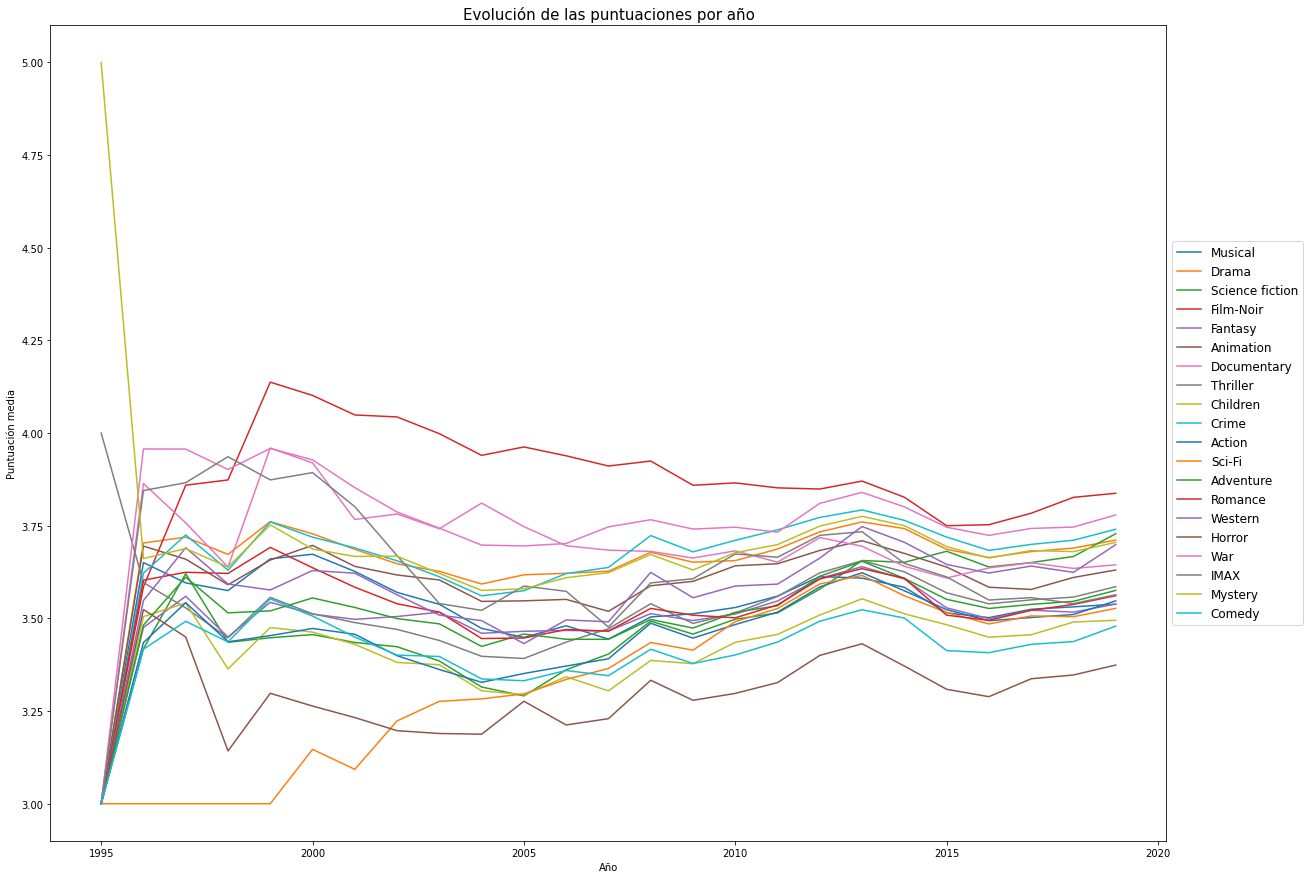

In [ ]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)

for genre in set_of_genres:
  plt.plot(dict_first_plot[genre][0], dict_first_plot[genre][1], label=genre)
  plt.title("Evolución de las puntuaciones por año", fontsize=15)
  plt.xlabel("Año", fontsize=10)
  plt.ylabel("Puntuación media", fontsize=10)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

In [ ]:
dict_second_plot = {year: [list(set_of_genres)] for year in all_years}

for year in all_years:
  punctuations_of_given_year = list()
  for genre in set_of_genres:
    punctuation = dict_second_goal[genre][year]
    if math.isnan(punctuation):
      # To improve the visualization readability
      punctuations_of_given_year.append(3)
    else:
      punctuations_of_given_year.append(punctuation)
  dict_second_plot[year].append(punctuations_of_given_year)

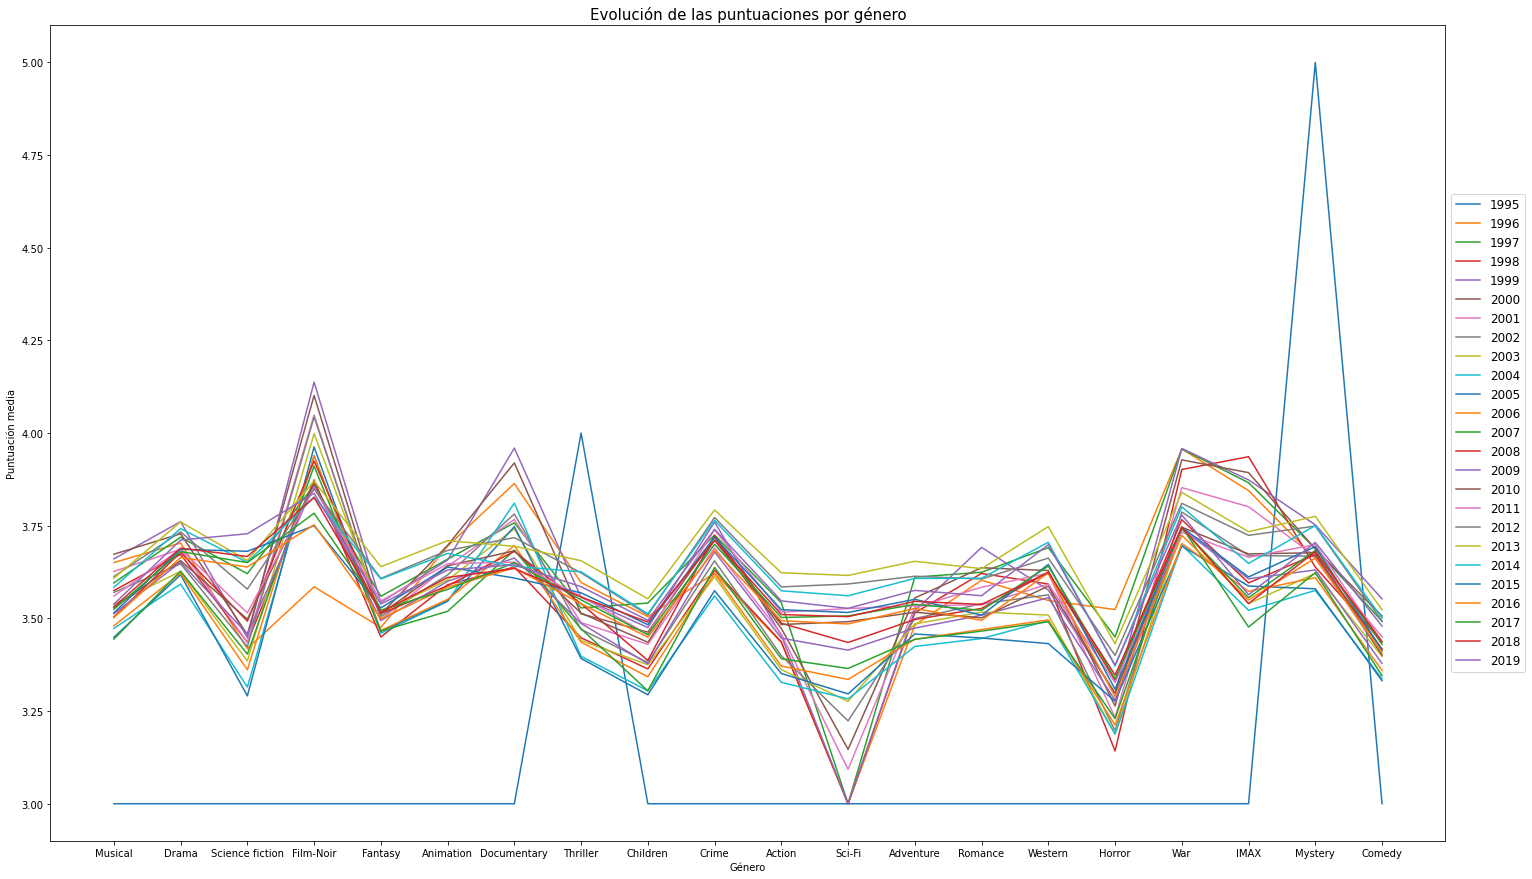

In [ ]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(15)

for year in all_years:
  plt.plot(dict_second_plot[year][0], dict_second_plot[year][1], label=year)
  plt.title("Evolución de las puntuaciones por género", fontsize=15)
  plt.xlabel("Género", fontsize=10)
  plt.ylabel("Puntuación media", fontsize=10)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# **5. Comentarios finales**

A lo largo del Notebook, se han ido destacando las diferentes limitaciones y desviaciones de los datos facilitados, además de las decisiones que se han ido tomando al respecto para el análisis.

Por último, cabe destacar por un lado que el año que nos da información más incompleta para todos los géneros analizados es el 1995, y que el género que mayor puntuación media tiene es el de "film-noir". Y por otro lado, ver que la amplia mayoría del resto de géneros están en el rango de puntuación media de entre 3.25 y 3.75 puntos.